In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!cp -r "drive/My Drive/ml_project/both/source1" "/content"

In [11]:
!cp -r "drive/My Drive/ml_project/both/target1" "/content"

In [143]:
path_src2="/content/drive/MyDrive/SOURCE-TARGET/2nd/source2"
path_tgt2="/content/drive/MyDrive/SOURCE-TARGET/2nd/target2"
path_src3="/content/drive/MyDrive/SOURCE-TARGET/3RD/source3"
path_tgt3="/content/drive/MyDrive/SOURCE-TARGET/3RD/target3"

In [124]:
!pip install nnmnkwii
!pip install pyroomacoustics
!pip install pyworld
!pip install pysptk
!pip install pydub

In [125]:
import pyroomacoustics as pra
import os
import numpy as np
import pandas as pd
import librosa
import pyworld
import pysptk
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.metrics import melcd
from sklearn.mixture import GaussianMixture
from nnmnkwii.baseline.gmm import MLPG
import librosa
import librosa.display
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython
from IPython.display import Audio
from pysptk.synthesis import MLSADF, Synthesizer
from pydub import AudioSegment
from pydub import AudioSegment
import librosa
import librosa.display


In [126]:
audio_file_mp3 = '/content/source1/0.mp3'
audio = AudioSegment.from_file(audio_file_mp3, format="mp3")

In [127]:
y = np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0

In [128]:
# Calculate log power spectrum
log_power_spectrum = librosa.amplitude_to_db(np.abs(librosa.stft(y))**2, ref=np.max)

In [129]:
# Set the sample rate to the original sample rate of the audio
sr = audio.frame_rate

In [130]:
order = 25  # the order of mel-cepstral coefficients
alpha = 0.97  # pre-emphasis coefficient
mc = pysptk.sp2mc(log_power_spectrum, order=order, alpha=alpha)

/usr/local/lib/python3.10/dist-packages/pysptk/conversion.py:102: RuntimeWarning: invalid value encountered in log
  logperiodogram = np.log(powerspec)
/usr/local/lib/python3.10/dist-packages/pysptk/conversion.py:102: RuntimeWarning: divide by zero encountered in log
  logperiodogram = np.log(powerspec)


#### Spectogram using log_power_spectrum

Text(0.5, 1.0, 'Spectrogram')

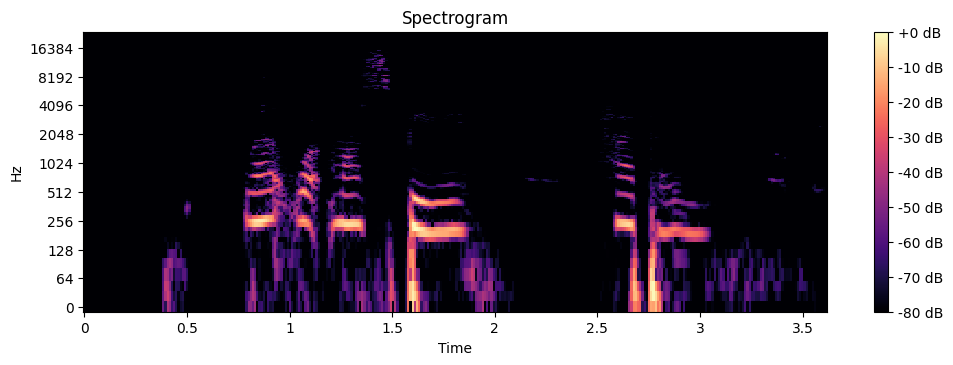

In [131]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(log_power_spectrum, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

#### spectogram using mfccs

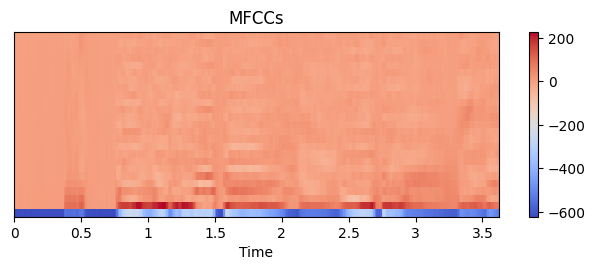

In [132]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=order)
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCCs')

plt.tight_layout()
plt.show()

#### CHROMA FEATURE:


In [133]:
hop_length=12
y,sr=librosa.load(audio_file_mp3)
chroma= librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)

Text(0.5, 1.0, 'chroma_feature')

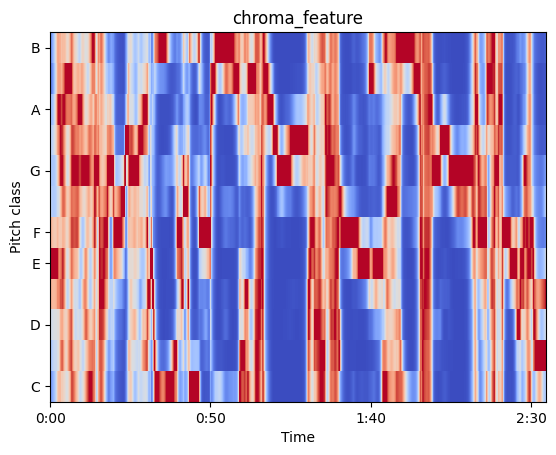

In [134]:
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('chroma_feature')

#### ZERO CROSSING RATE:

In [135]:
zer_feature = librosa.feature.zero_crossing_rate(y=y,frame_length = 1024,hop_length=512)[0]

Text(0.5, 1.0, 'zero_feature')

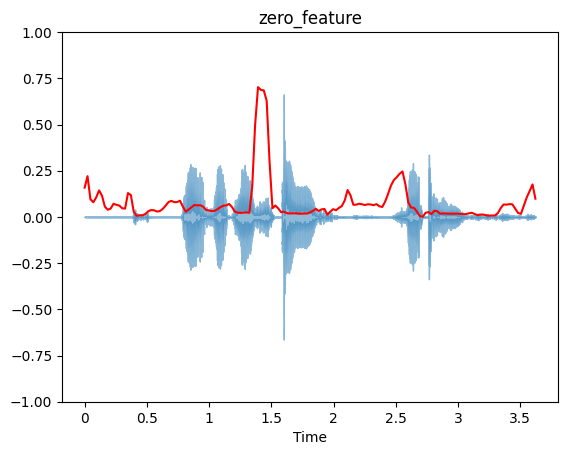

In [136]:
frames = range(len(zer_feature))
t = librosa.frames_to_time(frames, hop_length=512)
librosa.display.waveshow(y,alpha=0.5)
plt.plot(t, zer_feature, color="r")
plt.ylim((-1, 1))
plt.title('zero_feature')

#### Main:

####training data


In [137]:
fs = 10000
no_of_mc = 24
frame_period = 5
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
hop_length = int(fs * (frame_period * 0.001))
windows = [(0, 0, np.array([1.0]))]

In [197]:
path1="/content/source1"
path2="/content/target1"
train=[]
for i in range(50):
  name=str(i)
  name+=".mp3"
  p1=path1+"/"+name
  p2=path2+"/"+name
  x,fs=librosa.load(p1,sr=fs)
  x = x.astype(np.float64)
  f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
  f0 = pyworld.stonemask(x, f0, timeaxis, fs)
  spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
  mc_source = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
  chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
  chroma_stft=chroma_stft.T
  zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
  zer_feature=zer_feature.T
  mc_source=np.concatenate((mc_source,chroma_stft,zer_feature),axis=-1)
  x,fs=librosa.load(p2,sr=fs)
  x = x.astype(np.float64)
  f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
  f0 = pyworld.stonemask(x, f0, timeaxis, fs)
  spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
  mc_target= pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
  chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
  chroma_stft=chroma_stft.T
  zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
  zer_feature=zer_feature.T
  mc_target=np.concatenate((mc_target,chroma_stft,zer_feature),axis=-1)
  mc_source=mc_source[:,1:]
  mc_target=mc_target[:,1:]
  mini=min(len(mc_source),len(mc_target))
  mc_source=mc_source[:mini,:]
  mc_target=mc_target[:mini,:]
  train.extend(np.concatenate((mc_source,mc_target),axis=-1))



In [174]:
path1=path_src2
path2=path_tgt2
train2=[]
for i in range(35):
  name=str(i)
  name+=".mp3"
  p1=path1+"/"+name
  p2=path2+"/"+name
  x,fs=librosa.load(p1,sr=fs)
  x = x.astype(np.float64)
  f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
  f0 = pyworld.stonemask(x, f0, timeaxis, fs)
  spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
  mc_source = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
  chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
  chroma_stft=chroma_stft.T
  zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
  zer_feature=zer_feature.T
  mc_source=np.concatenate((mc_source,chroma_stft,zer_feature),axis=-1)
  x,fs=librosa.load(p2,sr=fs)
  x = x.astype(np.float64)
  f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
  f0 = pyworld.stonemask(x, f0, timeaxis, fs)
  spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
  mc_target= pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
  chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
  chroma_stft=chroma_stft.T
  zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
  zer_feature=zer_feature.T
  mc_target=np.concatenate((mc_target,chroma_stft,zer_feature),axis=-1)
  mc_source=mc_source[:,1:]
  mc_target=mc_target[:,1:]
  mini=min(len(mc_source),len(mc_target))
  mc_source=mc_source[:mini,:]
  mc_target=mc_target[:mini,:]
  train2.extend(np.concatenate((mc_source,mc_target),axis=-1))



In [175]:
path1=path_src3
path2=path_tgt3
train3=[]
for i in range(25):
  name=str(i)
  name+=".mp3"
  p1=path1+"/"+name
  p2=path2+"/"+name
  x,fs=librosa.load(p1,sr=fs)
  x = x.astype(np.float64)
  f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
  f0 = pyworld.stonemask(x, f0, timeaxis, fs)
  spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
  mc_source = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
  chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
  chroma_stft=chroma_stft.T
  zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
  zer_feature=zer_feature.T
  mc_source=np.concatenate((mc_source,chroma_stft,zer_feature),axis=-1)
  x,fs=librosa.load(p2,sr=fs)
  x = x.astype(np.float64)
  f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
  f0 = pyworld.stonemask(x, f0, timeaxis, fs)
  spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
  mc_target= pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
  chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
  chroma_stft=chroma_stft.T
  zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
  zer_feature=zer_feature.T
  mc_target=np.concatenate((mc_target,chroma_stft,zer_feature),axis=-1)
  mc_source=mc_source[:,1:]
  mc_target=mc_target[:,1:]
  mini=min(len(mc_source),len(mc_target))
  mc_source=mc_source[:mini,:]
  mc_target=mc_target[:mini,:]
  train3.extend(np.concatenate((mc_source,mc_target),axis=-1))



#### Training the GMM model

In [198]:
n_components=30
gmm = GaussianMixture(n_components=30, covariance_type="full", verbose=1,max_iter=150)
gmm.fit(train)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True


GaussianMixture(max_iter=150, n_components=30, verbose=1)

In [178]:
n_components=9
gmm2 = GaussianMixture(n_components=n_components, covariance_type="full", verbose=1,max_iter=150)
gmm2.fit(train2)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


GaussianMixture(max_iter=150, n_components=9, verbose=1)

In [189]:
n_components=5
gmm3 = GaussianMixture(n_components=n_components, covariance_type="full", verbose=1,max_iter=100)
gmm3.fit(train3)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


GaussianMixture(n_components=5, verbose=1)

Testing:

Source audio

In [199]:
IPython.display.Audio('/content/source1/62.mp3')   # source

Target Audio

In [200]:
IPython.display.Audio('/content/target1/62.mp3')    #target

Conversion:


In [204]:
paramgen = MLPG(gmm, windows=windows, diff=False)
x,fs = librosa.load("/content/source1/62.mp3",sr=fs)
x = x.astype(np.float64)
f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
f0 = pyworld.stonemask(x, f0, timeaxis, fs)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
mc = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
c0,mc=mc[:,0],mc[:,1:]
chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
chroma_stft=chroma_stft.T
zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
zer_feature=zer_feature.T
mc=np.concatenate((mc,chroma_stft,zer_feature),axis=-1)
mc = paramgen.transform(mc)
mc= mc[:, :no_of_mc]
mc = np.hstack((c0[:, None], mc))

In [205]:
mc_new=mc
mc_new[:, 0] = 0 # remove power coefficient, reduce feat dimension to MFCC order for speech synthesis
# print("Semi final MC", mc.shape, x.shape)
engine = Synthesizer(MLSADF(order=no_of_mc, alpha=alpha), hopsize=hop_length)
b_coeffs = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)  #MLSDAF coeffiecients
# print("Convertedn audio 2")
wave2 = engine.synthesis(x, b_coeffs)
IPython.display.display(Audio(wave2, rate=fs))     #converted2

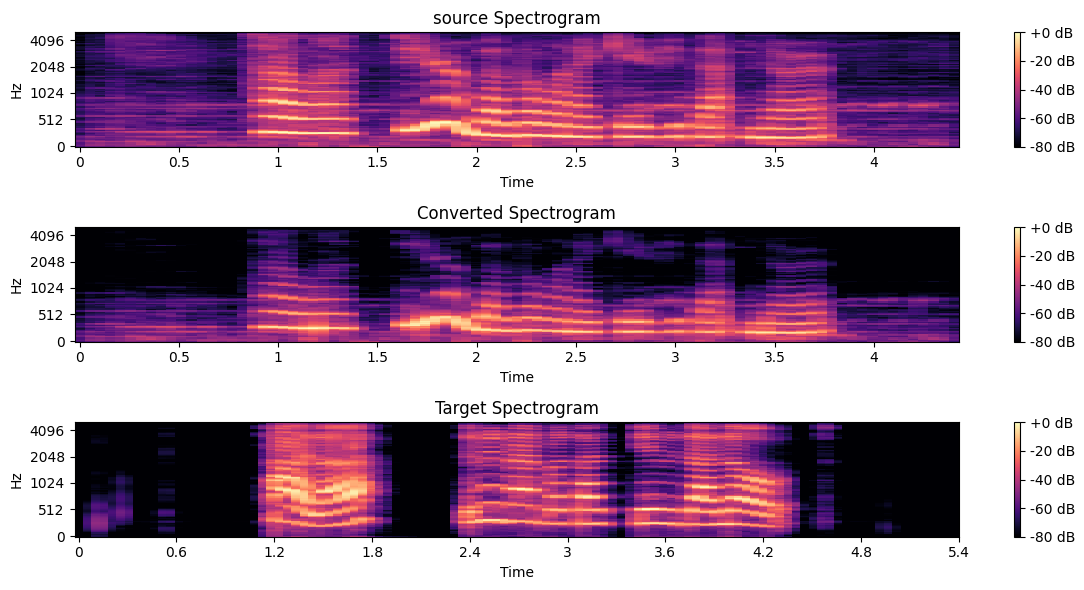

In [206]:
x_tgt,fs = librosa.load("/content/target1/62.mp3",sr=fs)
spec1 = librosa.feature.melspectrogram(y=x, sr=fs)
spec2 = librosa.feature.melspectrogram(y=wave2, sr=fs)
spec3 = librosa.feature.melspectrogram(y=x_tgt, sr=fs)
# Convert to decibels
spec_db1 = librosa.power_to_db(spec1, ref=np.max)
spec_db2 = librosa.power_to_db(spec2, ref=np.max)
spec_db3 = librosa.power_to_db(spec3, ref=np.max)
# Plotting spectrograms side by side using subplots
plt.figure(figsize=(12, 6))

plt.subplot(3,1, 1)
librosa.display.specshow(spec_db1, sr=fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('source Spectrogram')

plt.subplot(3,1, 2)
librosa.display.specshow(spec_db2, sr=fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Converted Spectrogram')
plt.subplot(3,1, 3)
librosa.display.specshow(spec_db3, sr=fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Target Spectrogram')
plt.tight_layout()
plt.show()


test for 2nd combination:

In [183]:
src_path=path_src2+"/"+"38.mp3"
tgt_path=path_tgt2+"/"+"38.mp3"
IPython.display.Audio(src_path)   # source

In [184]:
IPython.display.Audio(tgt_path)

In [207]:
paramgen = MLPG(gmm2, windows=windows, diff=False)
x,fs = librosa.load(src_path,sr=fs)
x = x.astype(np.float64)
f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
f0 = pyworld.stonemask(x, f0, timeaxis, fs)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
mc = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
c0,mc=mc[:,0],mc[:,1:]
chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
chroma_stft=chroma_stft.T
zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
zer_feature=zer_feature.T
mc=np.concatenate((mc,chroma_stft,zer_feature),axis=-1)
mc = paramgen.transform(mc)
mc= mc[:, :no_of_mc]
mc = np.hstack((c0[:, None], mc))
mc_new=mc
mc_new[:, 0] = 0 # remove power coefficient, reduce feat dimension to MFCC order for speech synthesis
# print("Semi final MC", mc.shape, x.shape)
engine = Synthesizer(MLSADF(order=no_of_mc, alpha=alpha), hopsize=hop_length)
b_coeffs = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)  #MLSDAF coeffiecients
wave2 = engine.synthesis(x, b_coeffs)
IPython.display.display(Audio(wave2, rate=fs))

test for 3rd combination

In [193]:
src_path=path_src3+"/"+"28.mp3"
tgt_path=path_tgt3+"/"+"28.mp3"
IPython.display.Audio(src_path)   # source

In [169]:
IPython.display.Audio(tgt_path)    #target

In [195]:
paramgen = MLPG(gmm3, windows=windows, diff=False)
x,fs = librosa.load(src_path,sr=fs)
x = x.astype(np.float64)
f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
f0 = pyworld.stonemask(x, f0, timeaxis, fs)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
mc = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
c0,mc=mc[:,0],mc[:,1:]
chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
chroma_stft=chroma_stft.T
zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
zer_feature=zer_feature.T
mc=np.concatenate((mc,chroma_stft,zer_feature),axis=-1)
mc = paramgen.transform(mc)
mc= mc[:, :no_of_mc]
mc = np.hstack((c0[:, None], mc))
mc_new=mc
mc_new[:, 0] = 0 # remove power coefficient, reduce feat dimension to MFCC order for speech synthesis
# print("Semi final MC", mc.shape, x.shape)
engine = Synthesizer(MLSADF(order=no_of_mc, alpha=alpha), hopsize=hop_length)
b_coeffs = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)  #MLSDAF coeffiecients
# print("Convertedn audio3")
wave= engine.synthesis(x, b_coeffs)
IPython.display.display(Audio(wave, rate=fs))

Testing script

In [ ]:
src_path=""
tgt_path=""
IPython.display.Audio(src_path)   # source

In [ ]:
IPython.display.Audio(tgt_path)    #target

In [ ]:
paramgen = MLPG(gmm_, windows=windows, diff=False)
x,fs = librosa.load(src_path,sr=fs)
x = x.astype(np.float64)
f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
f0 = pyworld.stonemask(x, f0, timeaxis, fs)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
mc = pysptk.sp2mc(spectrogram, order=no_of_mc, alpha=alpha)
c0,mc=mc[:,0],mc[:,1:]
chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs, hop_length=hop_length)
chroma_stft=chroma_stft.T
zer_feature = librosa.feature.zero_crossing_rate(y=x,hop_length=hop_length)
zer_feature=zer_feature.T
mc=np.concatenate((mc,chroma_stft,zer_feature),axis=-1)
mc = paramgen.transform(mc)
mc= mc[:, :no_of_mc]
mc = np.hstack((c0[:, None], mc))
mc_new=mc
mc_new[:, 0] = 0 # remove power coefficient, reduce feat dimension to MFCC order for speech synthesis
# print("Semi final MC", mc.shape, x.shape)
engine = Synthesizer(MLSADF(order=no_of_mc, alpha=alpha), hopsize=hop_length)
b_coeffs = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)  #MLSDAF coeffiecients
# print("Convertedn audio3")
wave= engine.synthesis(x, b_coeffs)
IPython.display.display(Audio(wave, rate=fs))

In [ ]:
x_tgt,fs = librosa.load("/content/target1/62.mp3",sr=fs)
spec1 = librosa.feature.melspectrogram(y=x, sr=fs)
spec2 = librosa.feature.melspectrogram(y=wave, sr=fs)
spec3 = librosa.feature.melspectrogram(y=x_tgt, sr=fs)
# Convert to decibels
spec_db1 = librosa.power_to_db(spec1, ref=np.max)
spec_db2 = librosa.power_to_db(spec2, ref=np.max)
spec_db3 = librosa.power_to_db(spec3, ref=np.max)
# Plotting spectrograms side by side using subplots
plt.figure(figsize=(12, 6))

plt.subplot(3,1, 1)
librosa.display.specshow(spec_db1, sr=fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('source Spectrogram')

plt.subplot(3,1, 2)
librosa.display.specshow(spec_db2, sr=fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Converted Spectrogram')
plt.subplot(3,1, 3)
librosa.display.specshow(spec_db3, sr=fs, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Target Spectrogram')
plt.tight_layout()
plt.show()
